In [1]:
!pip install vaderSentiment

     -------------------------------------- 126.0/126.0 kB 7.7 MB/s eta 0:00:00


In [4]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/ca/4a/49ceaa60945f2e0077c25117dd99c7e6efdea9cc970787d0637a36e39014/wordcloud-1.9.2-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 153.3/153.3 kB 3.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import re 
import nltk as nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import time
import math
import string
import gensim
import pyLDAvis
import os
import requests
import pprint
import seaborn as sns 
import matplotlib.pyplot as plt
#import pyLDAvis.gensim
#import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.simplefilter('ignore')

from IPython.display import clear_output
from wordcloud import WordCloud
from joblib import dump, load
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pyLDAvis.enable_notebook()
#nlp = spacy.load("en_core_web_sm")

In [2]:
import pandarallel
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### VADER (Valence Aware Dictionary and sEntiment Reasoner) 

In [3]:
analyzer = SentimentIntensityAnalyzer()

def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{} {}".format(sentence, sent))

In [44]:
%%time

df = pd.read_parquet('filter_data_senti.parquet', engine='pyarrow')
df.shape

CPU times: total: 141 ms
Wall time: 139 ms


(1650, 14)

In [45]:
df.sample(2, random_state = 42)

,date,title,text,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,article_length,title_length,clean_text_tokens,sentiment
482,2022-06-09,Standigm Signs MOU with Merck Korea for AI dru...,Standigm Signs MOU with Merck Korea for AI dru...,2022,6,9,3,Standigm Signs MOU with Merck Korea for AI dru...,Standigm Signs MOU with Merck Korea for AI dru...,"[standigm, signs, mou, merck, korea, ai, drug,...",5626,66,"[standigm, signs, mou, merck, korea, ai, drug,...",0
65,2020-06-03,Global Artificial Intelligence in the Educatio...,\nGlobal Artificial Intelligence in the Educat...,2020,6,3,2,Global Artificial Intelligence in the Educatio...,Global Artificial Intelligence in the Educatio...,"[global, artificial, intelligence, education, ...",7197,207,"[global, artificial, intelligence, education, ...",1


In [46]:
df.rename(columns={'sentiment': 'initial_senti'}, inplace=True)

In [47]:
df.sample(2, random_state = 42)

,date,title,text,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,article_length,title_length,clean_text_tokens,initial_senti
482,2022-06-09,Standigm Signs MOU with Merck Korea for AI dru...,Standigm Signs MOU with Merck Korea for AI dru...,2022,6,9,3,Standigm Signs MOU with Merck Korea for AI dru...,Standigm Signs MOU with Merck Korea for AI dru...,"[standigm, signs, mou, merck, korea, ai, drug,...",5626,66,"[standigm, signs, mou, merck, korea, ai, drug,...",0
65,2020-06-03,Global Artificial Intelligence in the Educatio...,\nGlobal Artificial Intelligence in the Educat...,2020,6,3,2,Global Artificial Intelligence in the Educatio...,Global Artificial Intelligence in the Educatio...,"[global, artificial, intelligence, education, ...",7197,207,"[global, artificial, intelligence, education, ...",1


In [48]:
columns_to_drop = ["title", "text"]
df = df.drop(columns=columns_to_drop)

In [49]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each token
def analyze_tokens(tokens):
    sentiment_scores = [analyzer.polarity_scores(token)["compound"] for token in tokens]
    return sentiment_scores

In [50]:
df["sentiment_scores"] = df["clean_text_tokens"].apply(analyze_tokens)

In [51]:
df.head(5)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,article_length,title_length,clean_text_tokens,initial_senti,sentiment_scores
0,2023-05-25,2023,5,25,3,PayPal Is Using AI to Supercharge Profits Nasdaq,PayPal Is Using AI to Supercharge Profits Nasd...,"[paypal, using, ai, supercharge, profits, nasdaq]",7090,48,"[paypal, using, ai, supercharge, profits, nasd...",0,"[0.0, 0.0, 0.0, 0.0, 0.4404, 0.0, 0.0, 0.0, 0...."
1,2023-02-24,2023,2,24,4,Facebook Parent Meta Wants to Show Its Still a...,Facebook Parent Meta Wants to Show Its Still a...,"[facebook, parent, meta, wants, show, still, b...",4689,76,"[facebook, parent, meta, wants, show, still, b...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.128, 0.0..."
2,2021-03-23,2021,3,23,1,Artificial Intelligence Market is Expected to ...,Artificial Intelligence Market is Expected to ...,"[artificial, intelligence, market, expected, g...",6953,122,"[artificial, intelligence, market, expected, g...",1,"[0.0, 0.4767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,2022-07-23,2022,7,23,5,Google fires employee who said its conversatio...,Google fires employee who said its conversatio...,"[google, fire, employee, said, conversation, a...",5754,62,"[google, fire, employee, said, conversation, a...",0,"[0.0, -0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,2021-06-22,2021,6,22,1,Radically oversimplified AI skintone tool coul...,Radically oversimplified AI skintone tool cou...,"[radically, oversimplified, ai, skintone, tool...",6406,81,"[radically, oversimplified, ai, skintone, tool...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [52]:
def calculate_average_without_zero(scores):
    non_zero_scores = [score for score in scores if score != 0]
    if len(non_zero_scores) > 0:
        return sum(non_zero_scores) / len(non_zero_scores)
    else:
        return 0  # Default value if there are no non-zero scores

df["average_sentiment"] = df["sentiment_scores"].apply(calculate_average_without_zero)

In [53]:
df["average_sentiment"] = df["sentiment_scores"].apply(lambda scores: sum(scores) / len(scores))

In [54]:
df.head(5)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,article_length,title_length,clean_text_tokens,initial_senti,sentiment_scores,average_sentiment
0,2023-05-25,2023,5,25,3,PayPal Is Using AI to Supercharge Profits Nasdaq,PayPal Is Using AI to Supercharge Profits Nasd...,"[paypal, using, ai, supercharge, profits, nasdaq]",7090,48,"[paypal, using, ai, supercharge, profits, nasd...",0,"[0.0, 0.0, 0.0, 0.0, 0.4404, 0.0, 0.0, 0.0, 0....",0.021070
1,2023-02-24,2023,2,24,4,Facebook Parent Meta Wants to Show Its Still a...,Facebook Parent Meta Wants to Show Its Still a...,"[facebook, parent, meta, wants, show, still, b...",4689,76,"[facebook, parent, meta, wants, show, still, b...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.128, 0.0...",0.014684
2,2021-03-23,2021,3,23,1,Artificial Intelligence Market is Expected to ...,Artificial Intelligence Market is Expected to ...,"[artificial, intelligence, market, expected, g...",6953,122,"[artificial, intelligence, market, expected, g...",1,"[0.0, 0.4767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.044022
3,2022-07-23,2022,7,23,5,Google fires employee who said its conversatio...,Google fires employee who said its conversatio...,"[google, fire, employee, said, conversation, a...",5754,62,"[google, fire, employee, said, conversation, a...",0,"[0.0, -0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.019945
4,2021-06-22,2021,6,22,1,Radically oversimplified AI skintone tool coul...,Radically oversimplified AI skintone tool cou...,"[radically, oversimplified, ai, skintone, tool...",6406,81,"[radically, oversimplified, ai, skintone, tool...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006995


In [55]:
print(df['average_sentiment'].describe())

count    1650.000000
mean        0.021336
std         0.014691
min        -0.057190
25%         0.012332
50%         0.021589
75%         0.030176
max         0.077654
Name: average_sentiment, dtype: float64


In [56]:
# %time df["sentiment_score"] = df["clean_text"].parallel_apply(lambda x : analyzer.polarity_scores(x)["compound"])

In [57]:
df['sentiment'] = np.where(df['average_sentiment'].astype(float) > 0, 'Positive', 'Negative')
df['sentiment'] = np.where(df['average_sentiment'].astype(float) == 0, 'Neutral', df['sentiment'])

In [58]:
df.sample(2, random_state = 42)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,article_length,title_length,clean_text_tokens,initial_senti,sentiment_scores,average_sentiment,sentiment
482,2022-06-09,2022,6,9,3,Standigm Signs MOU with Merck Korea for AI dru...,Standigm Signs MOU with Merck Korea for AI dru...,"[standigm, signs, mou, merck, korea, ai, drug,...",5626,66,"[standigm, signs, mou, merck, korea, ai, drug,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.025440,Positive
65,2020-06-03,2020,6,3,2,Global Artificial Intelligence in the Educatio...,Global Artificial Intelligence in the Educatio...,"[global, artificial, intelligence, education, ...",7197,207,"[global, artificial, intelligence, education, ...",1,"[0.0, 0.0, 0.4767, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.030844,Positive


In [59]:
df["initial_senti"].value_counts()

initial_senti
0    986
1    664
Name: count, dtype: int64

In [60]:
# Vader provides lesser no. of negative sentiment
df["sentiment"].value_counts()

sentiment
Positive    1530
Negative     102
Neutral       18
Name: count, dtype: int64

In [23]:
output_path = r"C:\Users\verma\OneDrive - The University of Chicago\Desktop\MSCA\QUARTER 4 SUMMER\NLP\FINAL PROJECT/senti_data.parquet"
df.to_parquet(output_path, index=False)

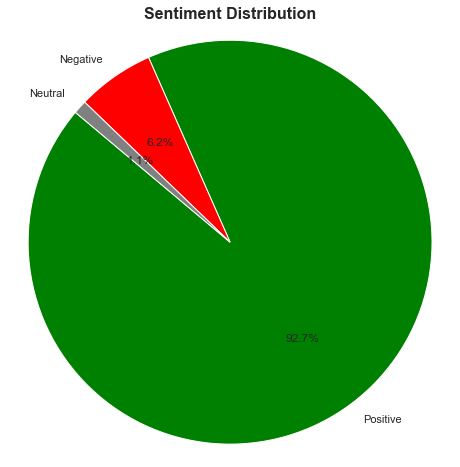

In [61]:
import matplotlib.pyplot as plt

# Get sentiment value counts from the "sentiment" column of the DataFrame
sentiment_counts = df["sentiment"].value_counts()

# Create a larger figure
plt.figure(figsize=(8, 8))

# Create a pie chart
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['green', 'red', 'gray'])

# Set the title
plt.title("Sentiment Distribution", fontsize=16, fontweight="bold")

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Save the plot as an image file (e.g., PNG) for use in your PPT
plt.savefig('sentiment_distribution_pie_chart.png', dpi=300)

# Show the plot (optional)
plt.show()

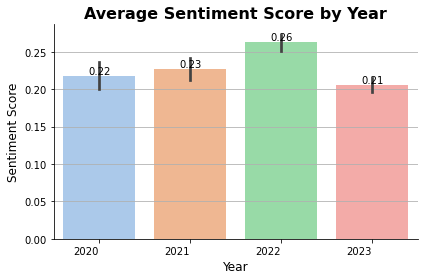

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
colors = sns.color_palette("pastel", len(df["year"].unique()))

# Create the bar plot with the custom color palette
ax = sns.barplot(x="year", y="average_sentiment", data=df, palette=colors)

# Set the title, x-axis label, and y-axis label
plt.title("Average Sentiment Score by Year", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Customize the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Add a horizontal grid
ax.yaxis.grid(True)

# Remove the top and right spines
sns.despine()

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

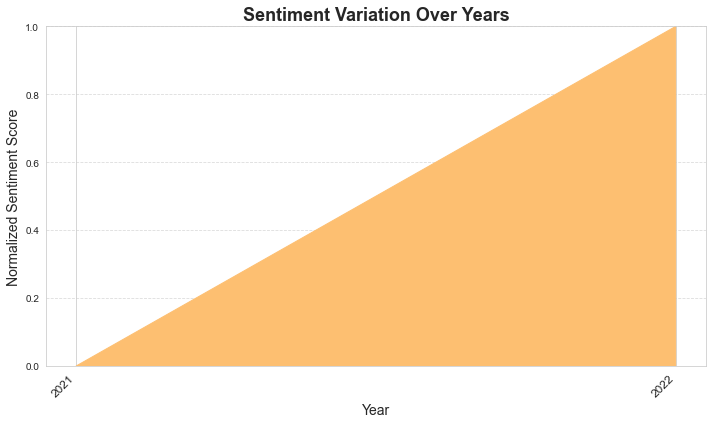

In [32]:
## Different visualization 1

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Normalize sentiment scores for color gradient
normalized_sentiments = (df['average_sentiment'] - df['average_sentiment'].min()) / (df['average_sentiment'].max() - df['average_sentiment'].min())

# Create a larger figure
plt.figure(figsize=(10, 6))

# Create the area plot with a custom color gradient
plt.fill_between(df['year'], 0, normalized_sentiments, color=sns.color_palette("RdYlBu", len(df['year'])))

# Set the title, x-axis label, and y-axis label
plt.title("Sentiment Variation Over Years", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Normalized Sentiment Score", fontsize=14)

# Customize the tick labels on the x-axis
plt.xticks(df['year'], rotation=45, ha='right', fontsize=12)

# Set y-axis limit from 0 to 1 for normalized sentiment scores
plt.ylim(0, 1)

# Add a horizontal grid
plt.grid(axis='y', linestyle='dashed', alpha=0.7)

# Adjust the figure layout
plt.tight_layout()

# Save the plot as an image file (e.g., PNG) for use in your PPT
plt.savefig('sentiment_variation_plot.png', dpi=300)

# Show the plot (optional)
plt.show()


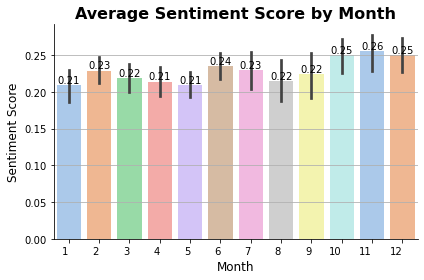

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
colors = sns.color_palette("pastel", len(df["month"].unique()))

# Create the bar plot with the custom color palette
ax = sns.barplot(x="month", y="average_sentiment", data=df, palette=colors)

# Set the title, x-axis label, and y-axis label
plt.title("Average Sentiment Score by Month", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Customize the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=10)

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Add a horizontal grid
ax.yaxis.grid(True)

# Remove the top and right spines
sns.despine()

# Adjust the figure layout to avoid cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [64]:
df.head(5)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,article_length,title_length,clean_text_tokens,initial_senti,sentiment_scores,average_sentiment,sentiment
0,2023-05-25,2023,5,25,3,PayPal Is Using AI to Supercharge Profits Nasdaq,PayPal Is Using AI to Supercharge Profits Nasd...,"[paypal, using, ai, supercharge, profits, nasdaq]",7090,48,"[paypal, using, ai, supercharge, profits, nasd...",0,"[0.0, 0.0, 0.0, 0.0, 0.4404, 0.0, 0.0, 0.0, 0....",0.021070,Positive
1,2023-02-24,2023,2,24,4,Facebook Parent Meta Wants to Show Its Still a...,Facebook Parent Meta Wants to Show Its Still a...,"[facebook, parent, meta, wants, show, still, b...",4689,76,"[facebook, parent, meta, wants, show, still, b...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.128, 0.0...",0.014684,Positive
2,2021-03-23,2021,3,23,1,Artificial Intelligence Market is Expected to ...,Artificial Intelligence Market is Expected to ...,"[artificial, intelligence, market, expected, g...",6953,122,"[artificial, intelligence, market, expected, g...",1,"[0.0, 0.4767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.044022,Positive
3,2022-07-23,2022,7,23,5,Google fires employee who said its conversatio...,Google fires employee who said its conversatio...,"[google, fire, employee, said, conversation, a...",5754,62,"[google, fire, employee, said, conversation, a...",0,"[0.0, -0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.019945,Positive
4,2021-06-22,2021,6,22,1,Radically oversimplified AI skintone tool coul...,Radically oversimplified AI skintone tool cou...,"[radically, oversimplified, ai, skintone, tool...",6406,81,"[radically, oversimplified, ai, skintone, tool...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006995,Positive


In [62]:
pos_text_corpus = ' '.join(df['clean_text'][df["sentiment"]=="Positive"].values)
neg_text_corpus = ' '.join(df['clean_text'][df["sentiment"]=="Negative"].values)

In [63]:
pos_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(pos_text_corpus)
plt.figure(figsize=(12, 8))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ValueError: Only supported for TrueType fonts

In [65]:
neg_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(neg_text_corpus)
plt.figure(figsize=(12, 8))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ValueError: Only supported for TrueType fonts